# Qredo tokenomics simulation - staking rewards parameters

### June 2023

## 1. Imports

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load and process data

In [3]:
# load
df_file = os.path.join(outfolder, f"sample_by_staking_params_and_scenario.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)  

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["validator_reward_share"] = df["validator_reward_share"].round(2)
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["validator_profit"] = df["av_validator_reward"] * df["token_price"] - 200.0
l = [np.log(2) / (i * 365) for i in [6.0,  4.0, 2.0]]
d = {
    l[0]: "6yrs half-life",
    l[1]: "4yrs half-life",
    l[2]: "2yrs half-life",
}
df['decay_rate'] = df['staking_rewards_vesting_decay_rate'].map(d)
df["release_rate_a"] = df["release_rate_a"].round(1)
df["release_rate_fn"] = "a=" + df["release_rate_a"].astype(str) + " max_rate=" + df["release_rate_max"].astype(str)
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released',"ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested','staking_rewards_ecosystem']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

10643400

In [4]:
base_df = df[df["token_scenario"]=="base"]
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]
combined_df["combined_scenario"] = combined_df["staking_scenario"]

## 3. Reward sources

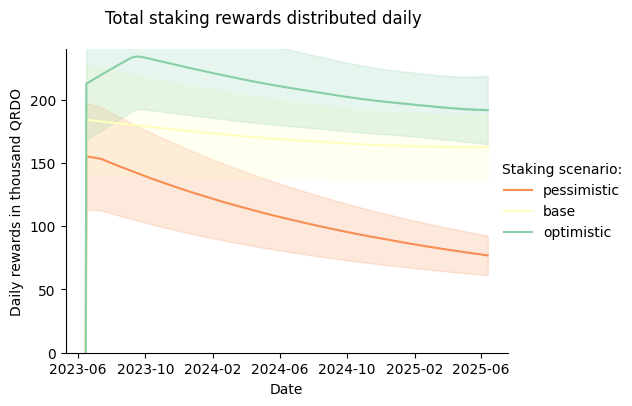

In [5]:
g = sns.relplot(data=df, x="date", y="total_staking_rewards", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Total staking rewards distributed daily")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

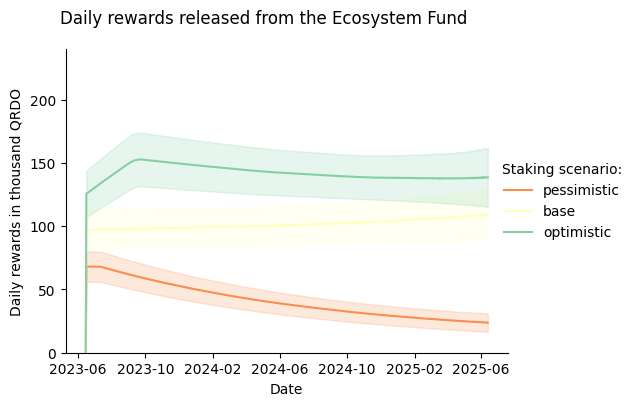

In [6]:
g = sns.relplot(data=df, x="date", y="staking_rewards_ecosystem", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards released from the Ecosystem Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

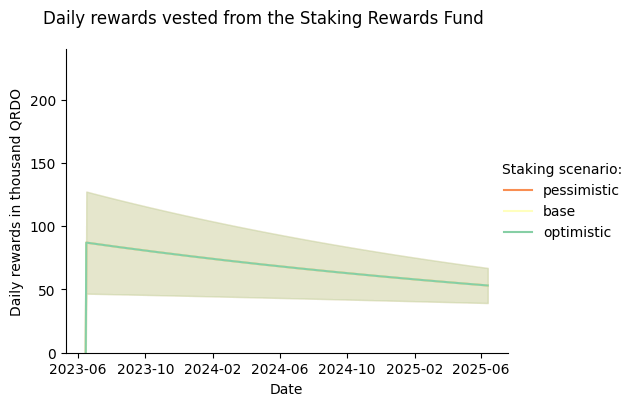

In [7]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

## 4. Parameter analysis - Validator reward share

### 4.1 Staker APR

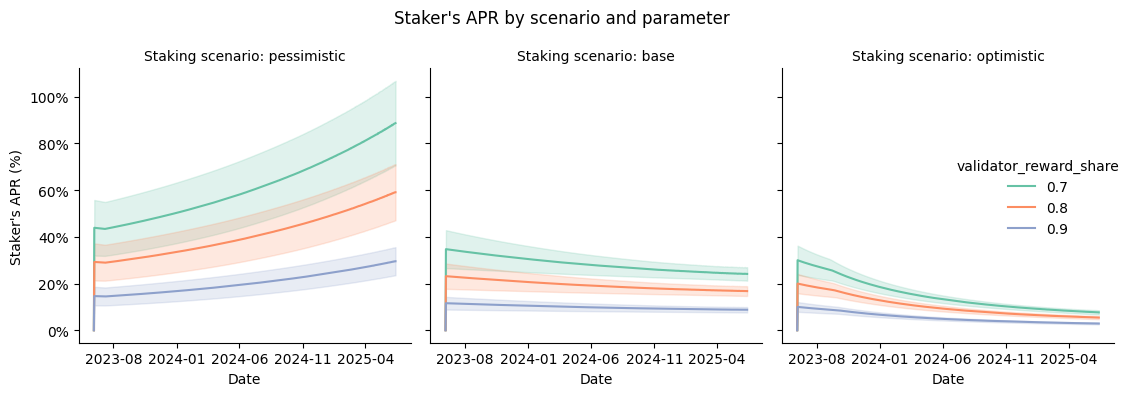

In [8]:
g = sns.relplot(data=df, x="date", y="apr", hue="validator_reward_share", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Staker's APR (%)").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
plt.show()

In [9]:
df.groupby(["staking_scenario", "validator_reward_share"])["apr"].mean()

staking_scenario  validator_reward_share
base              0.7                       0.282879
                  0.8                       0.193023
                  0.9                       0.098928
optimistic        0.7                       0.150243
                  0.8                       0.103726
                  0.9                       0.053806
pessimistic       0.7                       0.610664
                  0.8                       0.407114
                  0.9                       0.203557
Name: apr, dtype: float64

In [10]:
df.groupby(["validator_reward_share"])["apr"].mean().diff()

validator_reward_share
0.7         NaN
0.8   -0.113308
0.9   -0.115857
Name: apr, dtype: float64

### 4.2 Validator profit

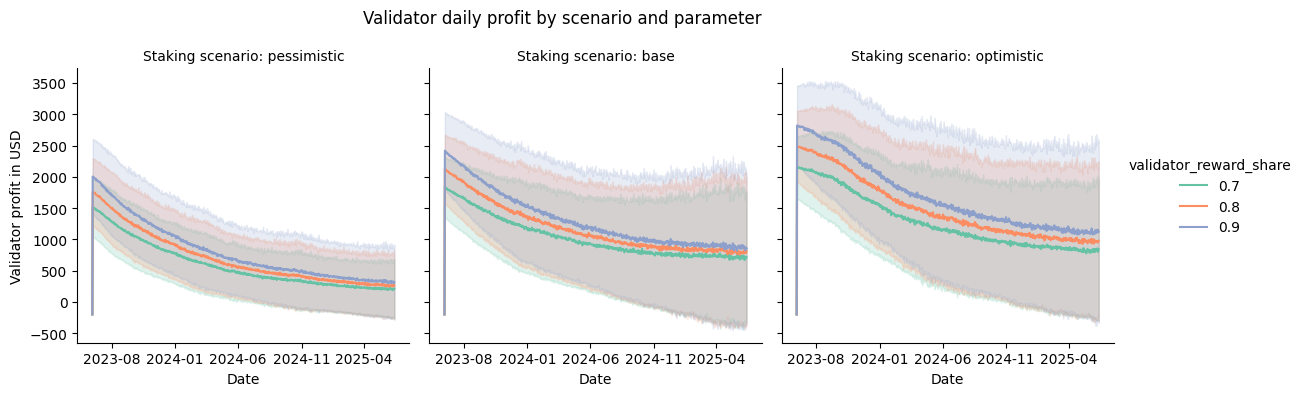

In [11]:
g = sns.relplot(data=df, x="date", y="validator_profit", hue="validator_reward_share", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Validator profit in USD").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [12]:
df.groupby(["staking_scenario", "validator_reward_share"])["validator_profit"].mean()

staking_scenario  validator_reward_share
base              0.7                       1022.641113
                  0.8                       1168.033846
                  0.9                       1306.155526
optimistic        0.7                       1278.353772
                  0.8                       1489.731711
                  0.9                       1698.987939
pessimistic       0.7                        583.272282
                  0.8                        694.256367
                  0.9                        806.402844
Name: validator_profit, dtype: float64

In [13]:
df.groupby(["validator_reward_share"])["validator_profit"].mean().diff()

validator_reward_share
0.7           NaN
0.8    155.918252
0.9    153.174795
Name: validator_profit, dtype: float64

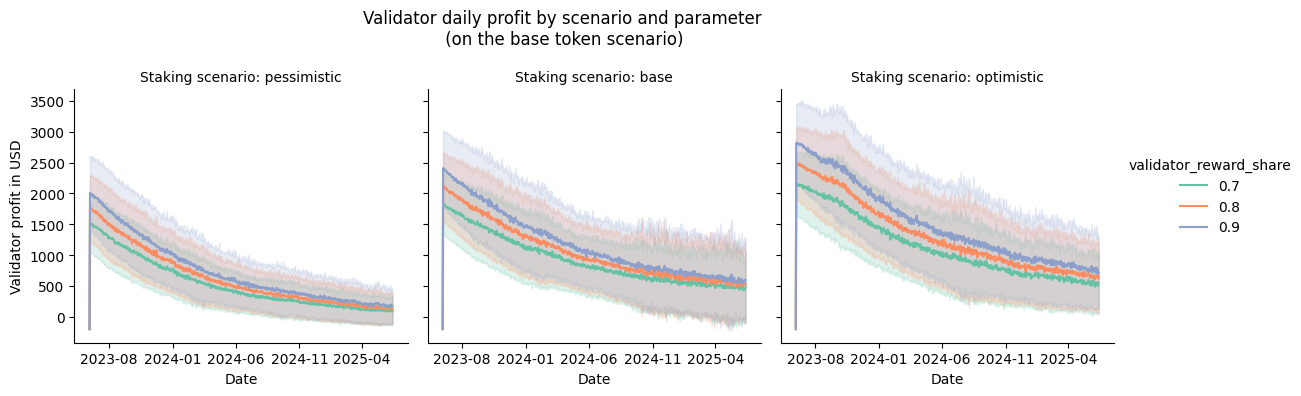

In [14]:
g = sns.relplot(data=base_df, x="date", y="validator_profit", hue="validator_reward_share", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Validator profit in USD").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit by scenario and parameter\n (on the base token scenario)")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [15]:
base_df.groupby(["iteration","staking_scenario", "validator_reward_share"])["validator_profit"].mean().tail(9)

iteration  staking_scenario  validator_reward_share
729        base              0.7                       492.280560
                             0.8                       531.052810
                             0.9                       595.824202
           optimistic        0.7                       550.160455
                             0.8                       620.904760
                             0.9                       712.526595
           pessimistic       0.7                        85.956424
                             0.8                       126.059005
                             0.9                       171.312071
Name: validator_profit, dtype: float64

## 5. Parameter analysis - vesting decay rate

### 5.1 Staker APR

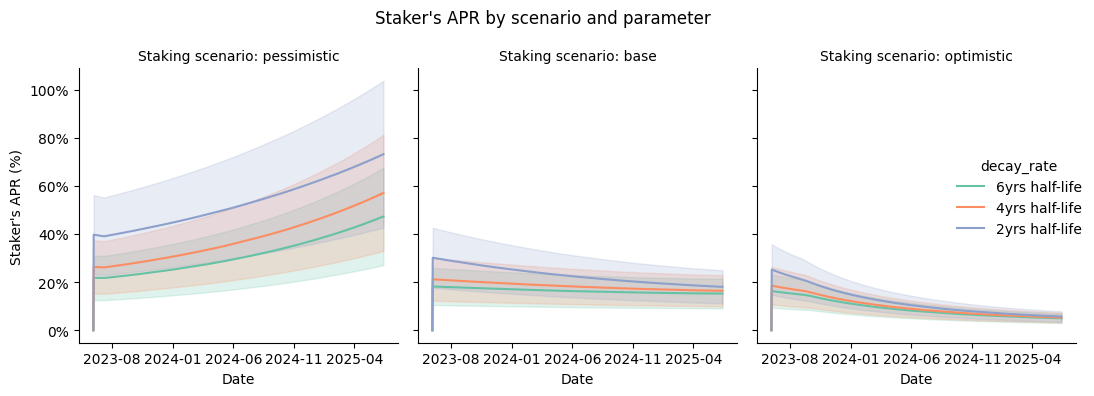

In [16]:
g = sns.relplot(data=df, x="date", y="apr", hue="decay_rate", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Staker's APR (%)").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
plt.show()

In [17]:
df.groupby(["staking_scenario", "decay_rate"])["apr"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    0.228097
                  4yrs half-life    0.183083
                  6yrs half-life    0.163650
optimistic        2yrs half-life    0.119126
                  4yrs half-life    0.098533
                  6yrs half-life    0.090115
pessimistic       2yrs half-life    0.528807
                  4yrs half-life    0.379685
                  6yrs half-life    0.312843
Name: apr, dtype: float64

In [18]:
df.groupby(["decay_rate"])["apr"].mean().diff()

decay_rate
2yrs half-life         NaN
4yrs half-life   -0.071576
6yrs half-life   -0.031564
Name: apr, dtype: float64

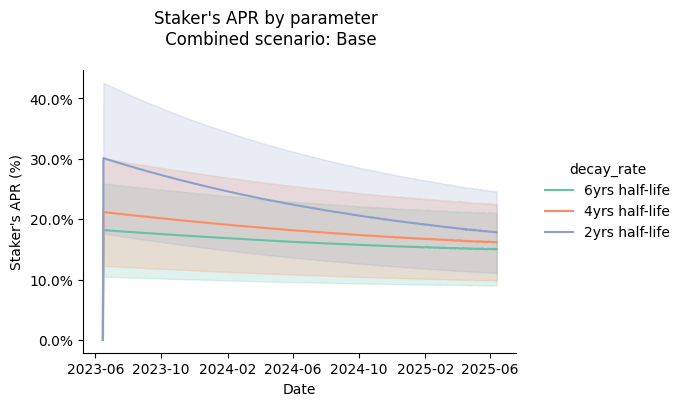

In [19]:
g = sns.relplot(data=combined_df[combined_df["combined_scenario"]=="base"], x="date", y="apr", 
                hue="decay_rate", kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by parameter \n Combined scenario: Base")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

### 5.2 Validator profit

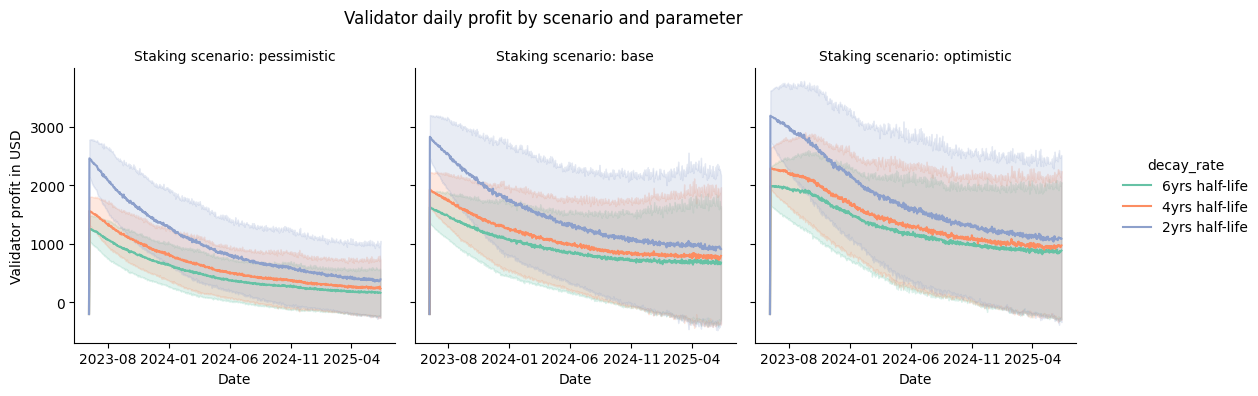

In [20]:
g = sns.relplot(data=df, x="date", y="validator_profit", hue="decay_rate", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Validator profit in USD").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [21]:
df.groupby(["staking_scenario", "decay_rate"])["validator_profit"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    1472.766358
                  4yrs half-life    1089.784928
                  6yrs half-life     934.279199
optimistic        2yrs half-life    1781.667728
                  4yrs half-life    1416.711991
                  6yrs half-life    1268.693703
pessimistic       2yrs half-life     980.724358
                  4yrs half-life     623.624881
                  6yrs half-life     479.582254
Name: validator_profit, dtype: float64

In [22]:
df.groupby(["decay_rate"])["validator_profit"].mean().diff()

decay_rate
2yrs half-life           NaN
4yrs half-life   -368.345548
6yrs half-life   -149.188881
Name: validator_profit, dtype: float64

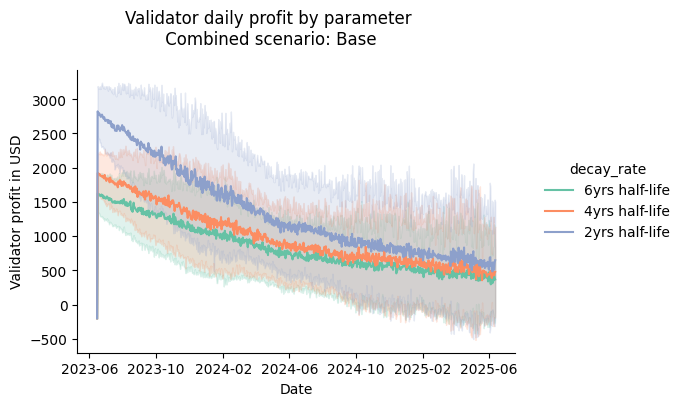

In [23]:
g = sns.relplot(data=combined_df[combined_df["combined_scenario"]=="base"], x="date", y="validator_profit", hue="decay_rate", 
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by parameter\n Combined scenario: Base")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

### 5.3 Inflation rates

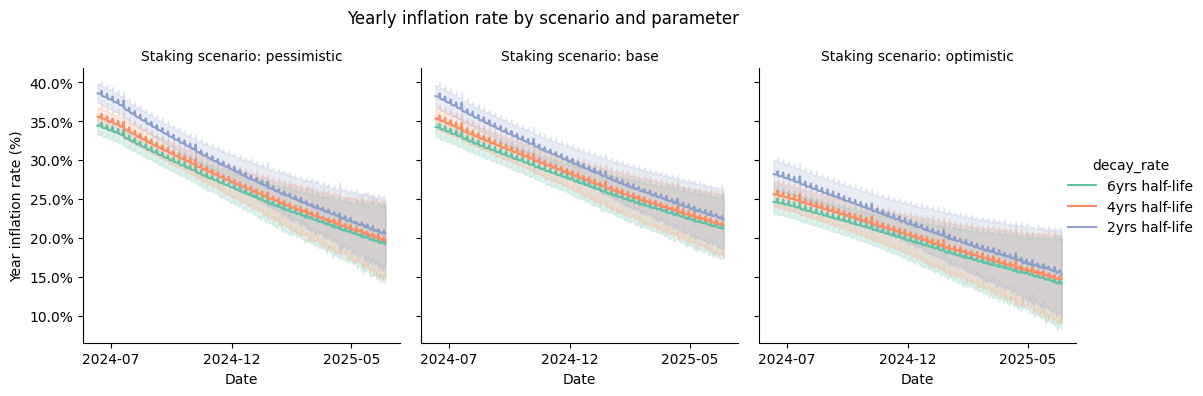

In [24]:
g = sns.relplot(data=df, x="date", y="year_inflation", hue="decay_rate", col="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=4, aspect=0.8)
g.set_axis_labels("Date", "Year inflation rate (%)").set_titles("Staking scenario: {col_name}")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.1, 0.5])
plt.show()

In [25]:
df.groupby(["staking_scenario", "decay_rate"])["year_inflation"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    0.296597
                  4yrs half-life    0.280499
                  6yrs half-life    0.273450
optimistic        2yrs half-life    0.216435
                  4yrs half-life    0.201265
                  6yrs half-life    0.194586
pessimistic       2yrs half-life    0.287190
                  4yrs half-life    0.270743
                  6yrs half-life    0.263527
Name: year_inflation, dtype: float64

In [26]:
df.groupby(["decay_rate"])["year_inflation"].mean().diff()

decay_rate
2yrs half-life         NaN
4yrs half-life   -0.015905
6yrs half-life   -0.006981
Name: year_inflation, dtype: float64

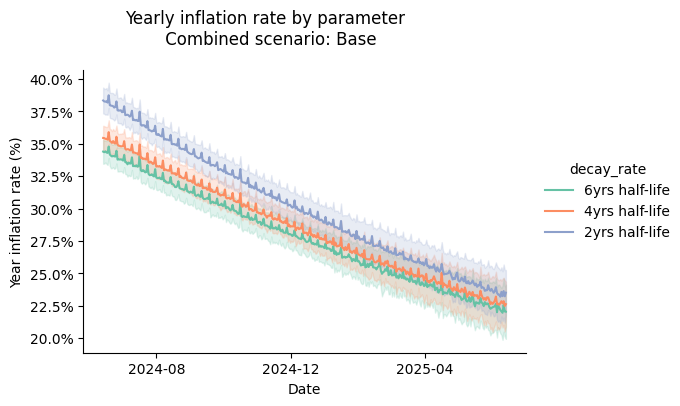

In [27]:
g = sns.relplot(data=combined_df[combined_df["combined_scenario"]=="base"], x="date", y="year_inflation", hue="decay_rate", 
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Year inflation rate (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate by parameter \n Combined scenario: Base")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

## 6. Parameter analysis - release rate function

### 6.1 Parameter space

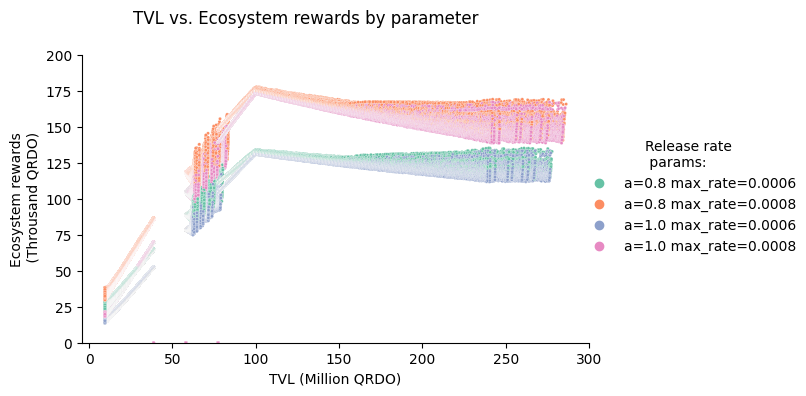

In [28]:
g = sns.relplot(data=combined_df, x="staking_tvl", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="scatter", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("TVL (Million QRDO)", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

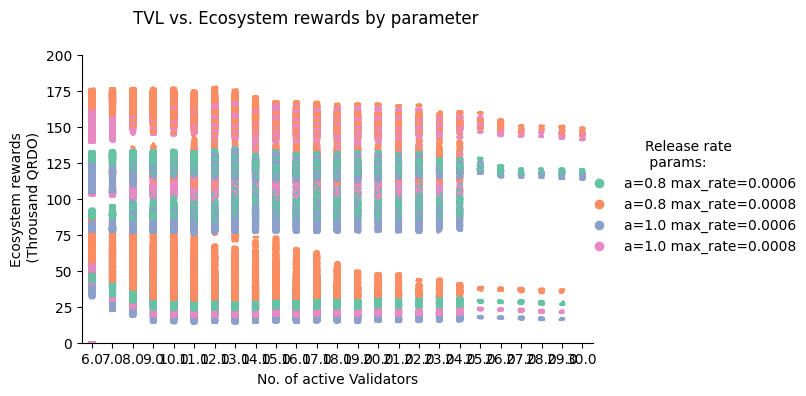

In [29]:
g = sns.catplot(data=combined_df, x="n_validators", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="strip", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("No. of active Validators", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

### 6.2 Staker APR

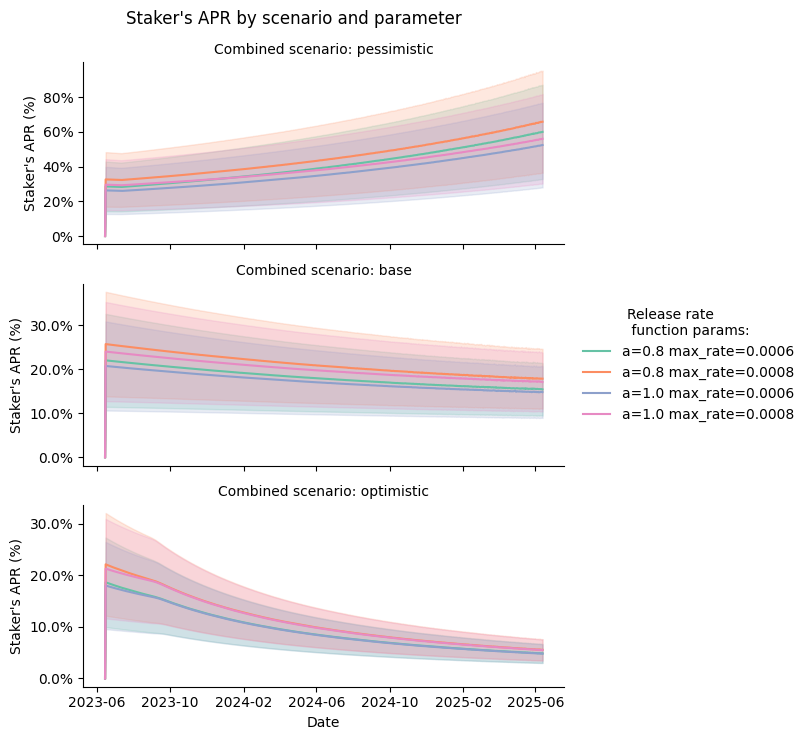

In [30]:
g = sns.relplot(data=combined_df, x="date", y="apr", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5, facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Staker's APR (%)")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[1][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[2][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.35, 0.5])
plt.show()

In [31]:
combined_df.groupby(["combined_scenario", "release_rate_fn"])["apr"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006    0.181456
                   a=0.8 max_rate=0.0008    0.210869
                   a=1.0 max_rate=0.0006    0.172159
                   a=1.0 max_rate=0.0008    0.199612
optimistic         a=0.8 max_rate=0.0006    0.094787
                   a=0.8 max_rate=0.0008    0.111101
                   a=1.0 max_rate=0.0006    0.093844
                   a=1.0 max_rate=0.0008    0.109951
pessimistic        a=0.8 max_rate=0.0006    0.407810
                   a=0.8 max_rate=0.0008    0.454027
                   a=1.0 max_rate=0.0006    0.363283
                   a=1.0 max_rate=0.0008    0.395992
Name: apr, dtype: float64

### 6.3 Validator Profit

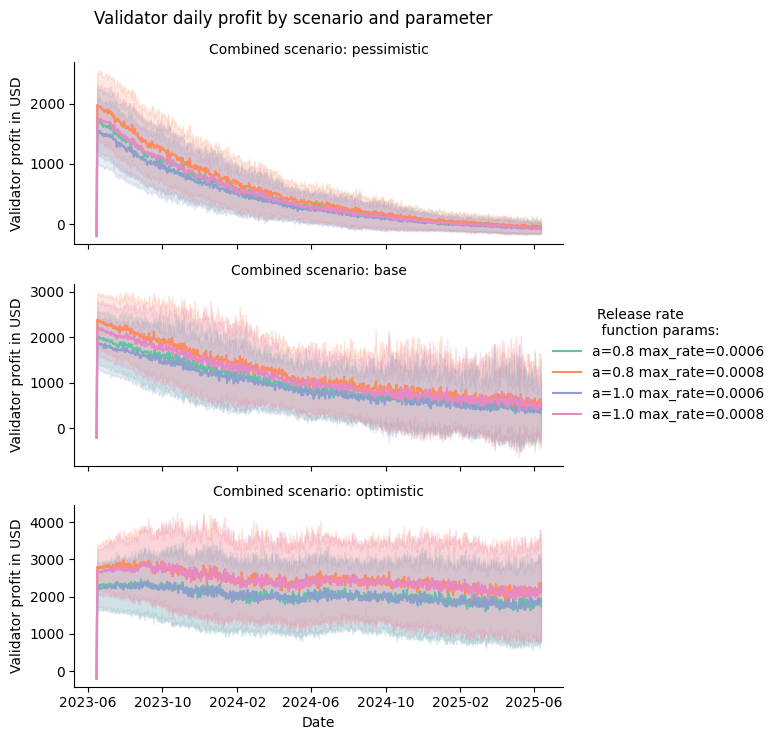

In [32]:
g = sns.relplot(data=combined_df, x="date", y="validator_profit", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5,facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Validator profit in USD")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [33]:
combined_df.groupby(["combined_scenario", "release_rate_fn"])["validator_profit"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006     989.661084
                   a=0.8 max_rate=0.0008    1203.553154
                   a=1.0 max_rate=0.0006     921.411897
                   a=1.0 max_rate=0.0008    1110.937856
optimistic         a=0.8 max_rate=0.0006    2036.003736
                   a=0.8 max_rate=0.0008    2451.109722
                   a=1.0 max_rate=0.0006    2015.649076
                   a=1.0 max_rate=0.0008    2423.322175
pessimistic        a=0.8 max_rate=0.0006     446.186812
                   a=0.8 max_rate=0.0008     527.264826
                   a=1.0 max_rate=0.0006     386.046830
                   a=1.0 max_rate=0.0008     447.165390
Name: validator_profit, dtype: float64

## 7. Parameter analysis - proposed paramaters

In [34]:
cond1 = (combined_df["validator_reward_share"]==0.8)
cond2 = (combined_df["decay_rate"]=="2yrs half-life")
cond3 = (combined_df["release_rate_fn"]=="a=0.8 max_rate=0.0006")

proposed_df = combined_df[cond1 & cond2 & cond3]

### 7.1 Staker APR

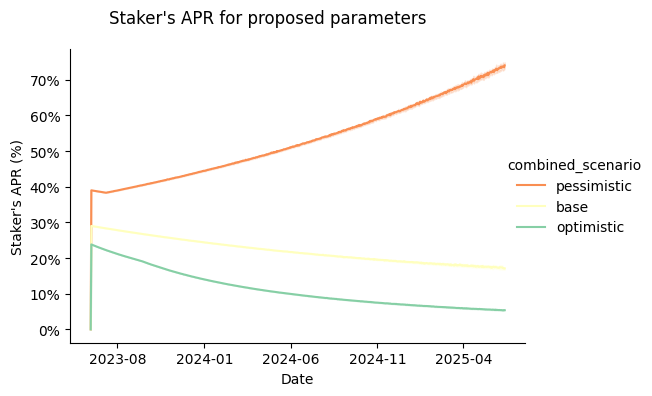

In [35]:
g = sns.relplot(data=proposed_df, x="date", y="apr", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4, aspect=1)
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR for proposed parameters")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.2, 0.5])
plt.show()

In [36]:
proposed_df.groupby(["combined_scenario"])["apr"].mean()

combined_scenario
base           0.220127
optimistic     0.112844
pessimistic    0.529471
Name: apr, dtype: float64

### 5.2 Validator profit

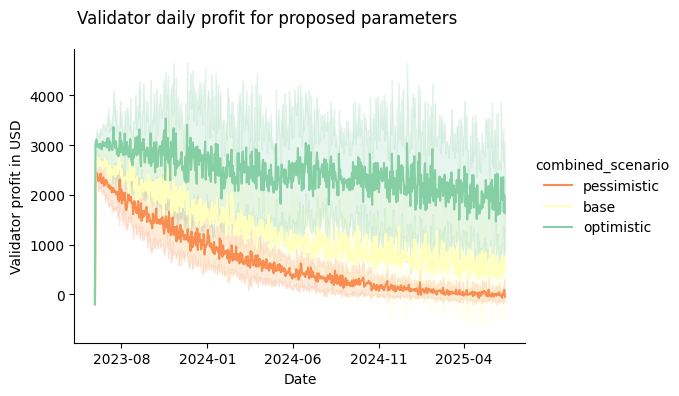

In [37]:
g = sns.relplot(data=proposed_df, x="date", y="validator_profit", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4, aspect=1)
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.suptitle("Validator daily profit for proposed parameters")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [38]:
proposed_df.groupby(["combined_scenario"])["validator_profit"].mean()

combined_scenario
base           1263.512728
optimistic     2441.276154
pessimistic     661.910053
Name: validator_profit, dtype: float64

### 5.3 Inflation rates

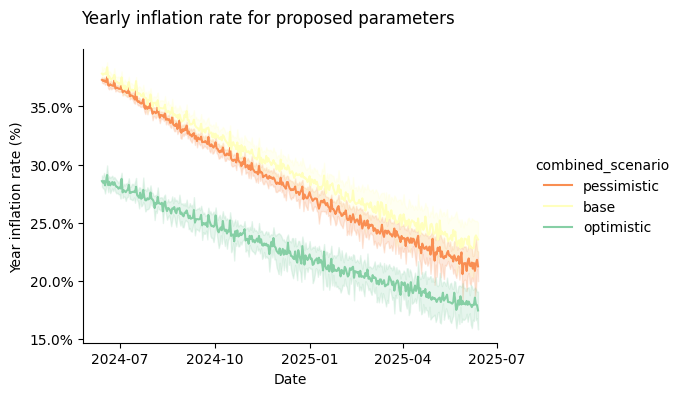

In [39]:
g = sns.relplot(data=proposed_df, x="date", y="year_inflation", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4, aspect=1)
g.set_axis_labels("Date", "Year inflation rate (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate for proposed parameters")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [40]:
proposed_df.groupby(["combined_scenario"])["year_inflation"].mean()

combined_scenario
base           0.297559
optimistic     0.227015
pessimistic    0.284586
Name: year_inflation, dtype: float64